In [ ]:
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
import numpy as np
import math
import gzip

from dataloader import MultimodalDataset, imageDataset
from network import ImageDataCNN, MixedDataCNN


# LINEAR REGRESSION MODEL

### Load in data

In [ ]:
# Load in the data
features_data = pd.read_csv('data\\features_preprocessed.csv')
target_data = pd.read_csv('data\\target_preprocessed.csv')

# split the data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features_data, target_data, test_size=0.2, random_state=42)

# further split the data into training and validation sets
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.1, random_state=42)

### Create, fit, and test Linear Regression Model

In [ ]:
# Creating and training the linear regression model
model = LinearRegression()
model.fit(features_train, target_train['age'])


# Making predictions on the validation set
predictions_valid = model.predict(features_val)
mse_valid = mean_squared_error(target_val['age'], predictions_valid)
print(f"Mean Squared Error on Validation Set: {mse_valid}")


# Making predictions on the test set
predictions_test = model.predict(features_test)
mse_test = mean_squared_error(target_test['age'], predictions_test)
print(f"Mean Squared Error on Test Set: {mse_test}")



# Graph the results for validation set
plt.scatter(target_val['age'], target_val['age'], color='blue', label='Actual Age (Validation)')
plt.scatter(target_val['age'], predictions_valid, color='red', label='Predicted Age (Validation)')
plt.xlabel("Sample")
plt.ylabel("Age")
plt.title("Linear Regression: Actual vs Predicted Ages (Validation Set)")
plt.legend()
plt.show()

# Graph the results for test set
plt.scatter(target_test['age'], target_test['age'], color='blue', label='Actual Age (Test)')
plt.scatter(target_test['age'], predictions_test, color='orange', label='Predicted Age (Test)')
plt.xlabel("Sample")
plt.ylabel("Age")
plt.title("Linear Regression: Actual vs Predicted Ages (Test Set)")
plt.legend()
plt.show()

# Convolutional Neural Network

### Load in data

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

# Load target data
image_target_data = pd.read_csv('data\\target_preprocessed.csv')

# Define the features (X) and the target variable (y)
target_age = image_target_data['age']
target_filename = image_target_data['filename']

# Split the data into training, validation, and test sets
target_age_train, target_age_test, target_filename_train, target_filename_test = train_test_split(target_age, target_filename, test_size=0.2, random_state=42)
target_age_test, target_age_val, target_filename_test, target_filename_val = train_test_split(target_age_test, target_filename_test, test_size=0.5, random_state=42)

# Convert ages to lists
target_age_train = target_age_train.tolist()
target_age_val = target_age_val.tolist()

# Convert filenames to list (not actual data that will be inputted)
target_filename_train = target_filename_train.tolist()
target_filename_val = target_filename_val.tolist()

# send test data to csv file for future testing
target_filename_test.to_csv('data\\CNN_filename_test.csv', index=False)
target_age_test.to_csv('data\\CNN_age_test.csv', index=False)

### Train CNN model

Epoch [1/10], Training Loss: 191.1510467529297, Validation Loss: 124.04926300048828
Epoch [2/10], Training Loss: 148.2454376220703, Validation Loss: 137.982421875
Epoch [3/10], Training Loss: 130.89866638183594, Validation Loss: 160.81842041015625
Epoch [4/10], Training Loss: 92.75125122070312, Validation Loss: 131.81417846679688
Epoch [5/10], Training Loss: 80.12245178222656, Validation Loss: 94.42994689941406
Epoch [6/10], Training Loss: 61.88307189941406, Validation Loss: 87.11719512939453
Epoch [7/10], Training Loss: 56.91520309448242, Validation Loss: 137.9560546875
Epoch [8/10], Training Loss: 41.85964584350586, Validation Loss: 101.38184356689453
Epoch [9/10], Training Loss: 35.251014709472656, Validation Loss: 168.74853515625
Epoch [10/10], Training Loss: 22.84029769897461, Validation Loss: 81.23905944824219


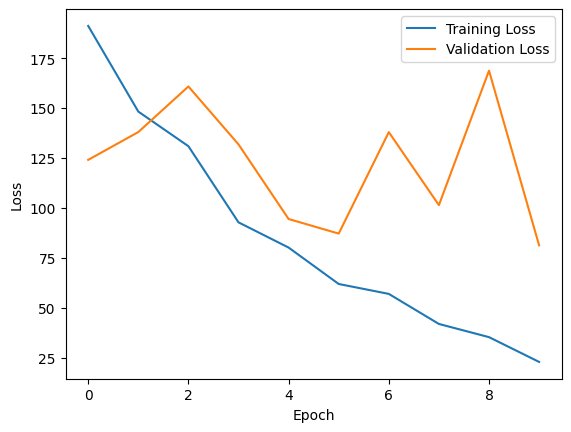

In [25]:
# Instantiate the model
model = ImageDataCNN()


# Define data loader
file_path = 'data\\images'
dataloader_train = imageDataset(file_path, 64, len(target_age_train), target_age_train, target_filename_train, False)
dataloader_val = imageDataset(file_path, 64, len(target_age_val), target_age_val, target_filename_val, True)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track losses
train_losses = []
val_losses = []


# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch_idx in range(dataloader_train.num_batches_per_epoch):
        image, target = dataloader_train.generate_batch()

        # Forward pass
        outputs = model(image)

        # Add a dimension for broadcasting purposes
        target = target.view(-1, 1)

        # Calculate loss
        loss = criterion(outputs, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_image, val_target = dataloader_val.generate_batch()

        # Forward pass
        val_outputs = model(val_image)

        # Add a dimension for broadcasting purposes
        val_target = val_target.view(-1, 1)

        # Calculate loss
        val_loss = criterion(val_outputs, val_target)

    # Append losses for plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

     # Save the model checkpoint with gzip compression
    checkpoint_path = f'model_checkpoints/nn_epoch_{epoch}.pth'
    torch.save({
        'model_state_dict': model.state_dict(), # only need to save the models state
    }, checkpoint_path)


# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Multimodal Convolutional Neural Network

### Load in data

In [26]:
# Load in the data
features_data = pd.read_csv('data\\features_preprocessed.csv')
image_data = 'data\\images' # <---- Not split, but rather called from disk with dataloader
target_data = pd.read_csv('data\\target_preprocessed.csv')

# split the data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features_data, target_data, test_size=0.2, random_state=42)

# further split the data into training and validation sets
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.1, random_state=42)

# Seperate out filenames and ages
target_age_train = target_train['age'].tolist()
target_filename_train = target_train['filename'].tolist()
target_features_train = features_train.values.tolist()

target_age_val = target_val['age'].tolist()
target_filename_val = target_val['filename'].tolist()
target_features_val = features_val.values.tolist()


# Send test data to csv file for future testing
features_test.to_csv('data\\Multi_CNN_features_test.csv', index=False)
target_test.to_csv('data\\Multi_CNN_target_test.csv', index=False)

### Train Multimodal CNN model

Epoch [1/10], Training Loss: 112.66170501708984, Validation Loss: 228.0753173828125
Epoch [2/10], Training Loss: 49.22408676147461, Validation Loss: 594.198974609375
Epoch [3/10], Training Loss: 40.18460464477539, Validation Loss: 430.4576416015625
Epoch [4/10], Training Loss: 35.235836029052734, Validation Loss: 388.9898376464844
Epoch [5/10], Training Loss: 29.37032127380371, Validation Loss: 484.6812438964844
Epoch [6/10], Training Loss: 24.252870559692383, Validation Loss: 464.2503356933594
Epoch [7/10], Training Loss: 20.527523040771484, Validation Loss: 492.07598876953125
Epoch [8/10], Training Loss: 17.287065505981445, Validation Loss: 508.07000732421875
Epoch [9/10], Training Loss: 14.592233657836914, Validation Loss: 490.8572998046875
Epoch [10/10], Training Loss: 12.136526107788086, Validation Loss: 490.4228515625


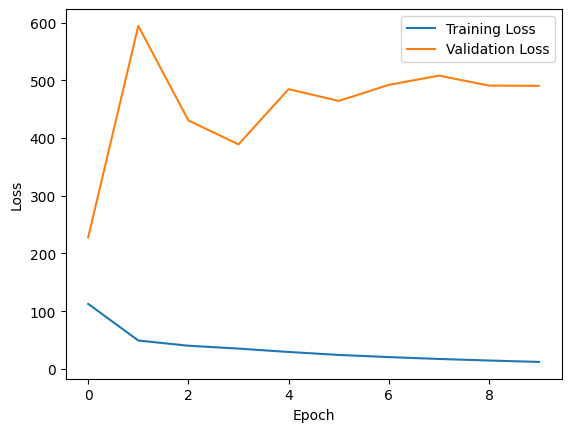

In [27]:
# Instantiate the model
model = MixedDataCNN(1, 5)

# Load Dataloaders
dataloader_train = MultimodalDataset(image_data, 128, len(features_train), target_age_train, target_features_train, target_filename_train, False)
dataloader_val =  MultimodalDataset(image_data, 128, len(features_val), target_age_val, target_features_val, target_filename_val, True)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track losses
train_losses = []
val_losses = []

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch_idx in range(dataloader_train.num_batches_per_epoch):
        image, target, feature = dataloader_train.generate_batch()

        # Forward pass
        outputs = model(image, feature)

        # Add a dimension for broadcasting purposes
        target = target.view(-1, 1)

        # Calculate loss
        loss = criterion(outputs, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_image, val_target, val_feature = dataloader_val.generate_batch()

        # Forward pass
        val_outputs = model(val_image, val_feature)

        # Add a dimension for broadcasting purposes
        val_target = val_target.view(-1, 1)

        # Calculate loss
        val_loss = criterion(val_outputs, val_target)

    # Append losses for plotting
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

    # Save the model checkpoint with gzip compression
    checkpoint_path = f'model_checkpoints/multi_nn_epoch_{epoch}.pth'
    torch.save({
        'model_state_dict': model.state_dict(), # only need to save the models state
    }, checkpoint_path)

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()